<a href="https://colab.research.google.com/github/Utpal-Mishra/Diabetes-Prediction/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICT DIABETES USING PIMA DIABETES DATA**

## Import Dependencies

### Mount Drive into Google Colab

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [32]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import xgboost


from sklearn import metrics

### Import Data
Pima Diabetes Data: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [33]:
url = '/content/drive/MyDrive/Data/Diabetes/pima-data.csv'
data = pd.read_csv(url)

print('Data Shape: {}\n'.format(data.shape))
print('Data Sample:')
data.head()

Data Shape: (768, 10)

Data Sample:


,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


## Exploratory Data Analysis

### Check for NULL Values

In [34]:
data.isnull().sum() # Check across all the variables

num_preg        0
glucose_conc    0
diastolic_bp    0
thickness       0
insulin         0
bmi             0
diab_pred       0
age             0
skin            0
diabetes        0
dtype: int64

### Check for MISSING Values

In [35]:
print('No.of Rows Missing Glucose Concentration: {0}'.format(len(data.loc[data['glucose_conc'] == 0])))
print('No.of Rows Missing Glucose Concentration: {0}'.format(len(data.loc[data['glucose_conc'] == 0])))
print('No.of Rows Missing Diastolic BP: {0}'.format(len(data.loc[data['diastolic_bp'] == 0])))
print('No.of Rows Missing Insulin: {0}'.format(len(data.loc[data['insulin'] == 0])))
print('No.of Rows Missing BMI: {0}'.format(len(data.loc[data['bmi'] == 0])))
print('No.of Rows Missing Diabetic Pred: {0}'.format(len(data.loc[data['diab_pred'] == 0])))
print('No.of Rows Missing Age: {0}'.format(len(data.loc[data['age'] == 0])))
print('No.of Rows Missing Skin: {0}'.format(len(data.loc[data['skin'] == 0])))

No.of Rows Missing Glucose Concentration: 5
No.of Rows Missing Glucose Concentration: 5
No.of Rows Missing Diastolic BP: 35
No.of Rows Missing Insulin: 374
No.of Rows Missing BMI: 11
No.of Rows Missing Diabetic Pred: 0
No.of Rows Missing Age: 0
No.of Rows Missing Skin: 227


### Check for Feature Relation via Correlation Matrix

Resources:
* Matplotlib DPI: https://www.geeksforgeeks.org/matplotlib-figure-figure-dpi-in-python/
*Heatmap: https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/

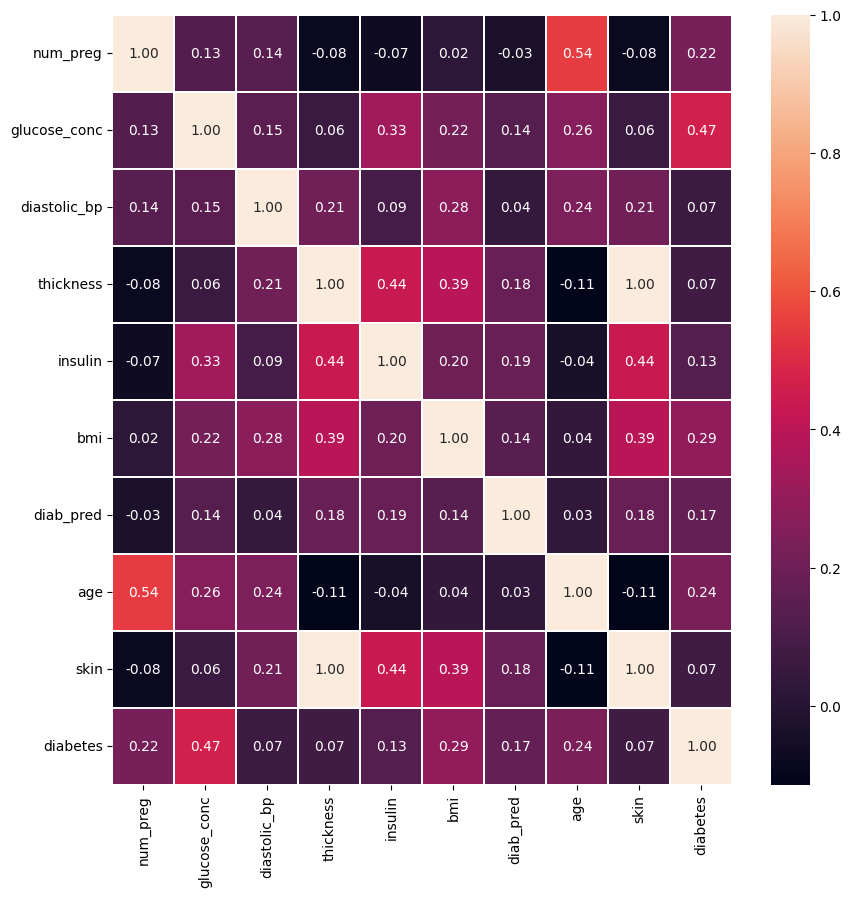

In [36]:
'''
corr_matrix = data.corr() # Correlation Matrix
top_corr_features = corr_matrix.index
plt.figure(figsize = (10, 10)) # Setting Plot Size
g = sns.heatmap(data[top_corr_features].corr(), annot = True, cmap = 'RdYlGn') # Building Heatmap
'''

plt.figure(figsize = (10, 10), dpi = 100) # dpi: resolution of dots per inch
sns.heatmap(data.corr(method = 'pearson'), annot=True, fmt=".2f", linewidth=.1) #sns.heatmap(data[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')
plt.show()

## Model Building

### Encoding Coding Predictor Variable

Resources:
* https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques

In [37]:
diabetes_map = {True: 1, False: 0}
data['diabetes'] = data['diabetes'].map(diabetes_map)
data.tail()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
763,10,101,76,48,180,32.9,0.171,63,1.8912,0
764,2,122,70,27,0,36.8,0.340,27,1.0638,0
765,5,121,72,23,112,26.2,0.245,30,0.9062,0
766,1,126,60,0,0,30.1,0.349,47,0.0000,1
767,1,93,70,31,0,30.4,0.315,23,1.2214,0


In [38]:
diabetes_true_count = len(data.loc[data['diabetes'] == True])
diabetes_false_count = len(data.loc[data['diabetes'] == False])
print(diabetes_true_count, diabetes_false_count)

268 500


### Feature Selection and Train/ Test Split

Resources:
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [39]:
feature_columns = ['num_preg', 'glucose_conc', 'diastolic_bp', 'thickness', 'insulin', 'bmi', 'diab_pred', 'age', 'skin']
predicted_class = ['diabetes']

X = data[feature_columns].values
Y = data[predicted_class].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 10)
print('X_train: {}, X_test: {}, Y_train: {}, Y_test: {}'.format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train: (614, 9), X_test: (154, 9), Y_train: (614, 1), Y_test: (154, 1)


### Handling Missing Data

Resources:
* https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/

In [40]:
fill_values = SimpleImputer(missing_values = 0, strategy = 'mean')

X_train = fill_values.fit_transform(X_train)
X_test = fill_values.fit_transform(X_test)

### Building Random Forest Classifier

Resources:
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
rf_model = RandomForestClassifier(random_state = 10)
rf_model.fit(X_train, Y_train.ravel())

Y_pred = rf_model.predict(X_test)
print('Model Accuracy on Test Set: {0:.3f}'.format(metrics.accuracy_score(Y_test, Y_pred)))

Model Accuracy on Test Set: 0.734


### Building XGBoost Classifier

Resources:
* https://xgboost.readthedocs.io/en/stable/

Defining Parameters

In [42]:
params = {
    'learning_rate'   : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth'       : [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma'           : [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

xg_model = xgboost.XGBClassifier()
random_search = RandomizedSearchCV(xg_model, param_distributions = params, n_iter = 5, scoring = 'roc_auc', n_jobs = -1, cv = 5, verbose = 3)

Observing Time Taken for Random Search

In [43]:
def timer(start_time = None):
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('\nTime Taken: {} Hours {} Minutes {} Seconds'.format(thour, tmin, round(tsec, 2)))

start_time = timer(None)
random_search.fit(X_train, Y_train.ravel())
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Time Taken: 0.0 Hours 0.0 Minutes 2.95 Seconds


Best Set of Estimator with Random Search

In [44]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Re-building XGBoost Classifier**

In [45]:
xg_model = xgboost.XGBClassifier(base_score = 0.5,
                                 booster = 'gbtree',
                                 colsample_bylevel = 1,
                                 colsample_bytree = 0.7,
                                 gamma = 0.1,
                                 learning_rate = 0.05,
                                 max_delta_step = 0,
                                 max_depth = 5,
                                 min_child_weight = 7,
                                 #missing = None,
                                 n_estimators = 100,
                                 n_jobs = 1,
                                 nthread = None,
                                 objective = 'binary:logistic',
                                 random_state = 0,
                                 reg_alpha = 0,
                                 reg_lambda = 1,
                                 scale_pos_weight = 1,
                                 seed = None,
                                 #silent = True,
                                 subsample = 1)

score = cross_val_score(xg_model, X_train, Y_train.ravel(), cv = 10)
print('Model Accuracy with Cross-Validation: {}'.format(round(score.mean(), 3)))

Model Accuracy with Cross-Validation: 0.774


Model Performance

In [46]:
xg_model.fit(X_train, Y_train)
Y_pred = xg_model.predict(X_test)

cm = metrics.confusion_matrix(Y_test, Y_pred)
#print(cm)
score = metrics.accuracy_score(Y_test, Y_pred)
print('Model Accuracy on Test Set: {}'.format(round(score, 3)))

Model Accuracy on Test Set: 0.727
